<a href="https://colab.research.google.com/github/AlePol27/2022_ML_Earth_Env_Sci/blob/main/Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ML final project - Ranking Features for Landslide Prediction
##### Alessio Poloni

## Part I: Load data

This cell contains an initial set up.

*Source: Prof. Tom Beucler's notebooks</a>.*

In [ ]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Is this notebook running on Colab or Kaggle?
IS_COLAB = "google.colab" in sys.modules

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
rnd_seed = 42
rnd_gen = np.random.default_rng(rnd_seed)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

The necessary dataset is stored on Google Drive. The next cells allow the data to be retrieved and loaded into the notebook.

*Source: <a href="https://sigmundojr.medium.com/how-do-i-read-a-csv-file-from-google-drive-using-python-colab-966091922852">Sigmundo Preissler Jr, PhD</a>.*

Installation of required imports:

In [ ]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

Authentication with Google account (when a window opens -> allow):

In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

Creation of the file and import of .csv data file:

In [ ]:
fileDownloaded = drive.CreateFile({'id':'1VtBalvWeWV2WtEPf5M19XP8sSnxAG135'})
fileDownloaded.GetContentFile('LS_good_5m_pro.csv')

Generation of Pandas dataframe:

In [ ]:
import pandas as pd
###
vardf = pd.read_csv('LS_good_5m_pro.csv', delimiter=',')

Finally, it's possible to create a geodataframe for the imported file (with Geopandas).

*Code adapted from: Prof. Tom Beucler's notebooks</a>.*

In [ ]:
%pip install geopandas
import geopandas as gpd #necessary import

In [ ]:
#Coordinates are already in the imported dataset
vardf = gpd.GeoDataFrame(vardf,
                      geometry=gpd.points_from_xy(np.float64(vardf.x), 
                                                  np.float64(vardf.y)))
vardf.head()

,x,y,GSS,DEM,slope,planCurv,profCurv,distRoad,landCover,TWI,geology,geometry
0,567895.5,200099.5,1,437.746155,8.737924,-0.000748,0.012272,145.000000,21,7.799716,24,POINT (567895.500 200099.500)
1,568095.5,200079.5,1,451.840485,10.511221,0.039531,-0.080413,5.000000,11,4.903382,24,POINT (568095.500 200079.500)
2,567905.5,200044.5,1,459.606934,23.602930,0.020892,-0.144569,98.994949,15,4.046845,24,POINT (567905.500 200044.500)
3,567950.5,200029.5,1,458.156433,13.160677,0.040629,-0.046540,56.568542,15,5.365241,24,POINT (567950.500 200029.500)
4,567800.5,199999.5,1,460.311768,20.403830,-0.005813,-0.020053,138.654251,21,5.817281,24,POINT (567800.500 199999.500)


## Part II: Preprocessing

The table is checked to delete eventual NaN data:

In [ ]:
vardf.dropna()
vardf.head()
#No NaN data found

,x,y,GSS,DEM,slope,planCurv,profCurv,distRoad,landCover,TWI,geology,geometry
0,567895.5,200099.5,1,437.746155,8.737924,-0.000748,0.012272,145.000000,21,7.799716,24,POINT (567895.500 200099.500)
1,568095.5,200079.5,1,451.840485,10.511221,0.039531,-0.080413,5.000000,11,4.903382,24,POINT (568095.500 200079.500)
2,567905.5,200044.5,1,459.606934,23.602930,0.020892,-0.144569,98.994949,15,4.046845,24,POINT (567905.500 200044.500)
3,567950.5,200029.5,1,458.156433,13.160677,0.040629,-0.046540,56.568542,15,5.365241,24,POINT (567950.500 200029.500)
4,567800.5,199999.5,1,460.311768,20.403830,-0.005813,-0.020053,138.654251,21,5.817281,24,POINT (567800.500 199999.500)


In this section two tables are created: one with predictive variables (independent variables) and one with the landslide absence/presence (dependent variable).

For the first table, the 8 predictor variables are selected and put into a geodataframe:

DEM -> Digital Elevation Model (m a.s.l)

Slope -> Slope (°)

Plan Curvature -> Surface curvature perpendicular to the direction of the maximum slope

Profile Curvature -> Surface curvature parallel to the direction of the maximum slope

Distance from Roads -> Distance (m) from main and secondary roads

Land Cover -> Physical material at the surface (like grass, concrete, trees, water, etc)

TWI -> Topographic Wetness Index: (ln(a/tan(b))) where a = upslope area draining through a certain point, and tan(b) = slope in radians

Geology classes -> Lithology classes

In [ ]:
DEM = vardf.DEM #Digital Elevation Model
slope = vardf.slope #Slope
planCurv = vardf.planCurv #Plan Curvature
profCurv = vardf.profCurv #Profile Curvature
distRoad = vardf.distRoad #Distance from Roads
landCover = vardf.landCover #Land Cover
TWI = vardf.TWI #Topographic Wetness Index
geology = vardf.geology #Lithology Class

In [ ]:
input_data = gpd.GeoDataFrame({'DEM':DEM, 'slope':slope, 'planCurv':planCurv, 'profCurv':profCurv, 'distRoad':distRoad, 'landCover':landCover, 'TWI':TWI, 'geology':geology})
input_data #table with independent variables

,DEM,slope,planCurv,profCurv,distRoad,landCover,TWI,geology
0,437.746155,8.737924,-0.000748,0.012272,145.000000,21,7.799716,24
1,451.840485,10.511221,0.039531,-0.080413,5.000000,11,4.903382,24
2,459.606934,23.602930,0.020892,-0.144569,98.994949,15,4.046845,24
3,458.156433,13.160677,0.040629,-0.046540,56.568542,15,5.365241,24
4,460.311768,20.403830,-0.005813,-0.020053,138.654251,21,5.817281,24
...,...,...,...,...,...,...,...,...
5183,451.893799,1.660977,-0.005359,0.001711,241.298569,21,12.846220,1
5184,2197.191650,25.800716,0.093662,-0.004219,1674.820923,51,3.945750,7
5185,628.142700,37.131775,-0.026372,0.002024,189.274933,41,4.883382,1
5186,445.515076,0.898599,0.003541,-0.002232,98.615417,15,9.319879,9


For the second table, the presence (1)/absence (0) for each observation is reported:

In [ ]:
#This data correspond to the GSS column in the original dataset
output_data = vardf.GSS #Presence = 1; Absence = 0 for landslides
output = gpd.GeoDataFrame({'GSS': output_data})
output #table with dependent variable

,GSS
0,1
1,1
2,1
3,1
4,1
...,...
5183,0
5184,0
5185,0
5186,0


## Part III: Random Forest Classifier implementation

Subdivision of the dataset into train (67%) and test (33%) sets:

In [ ]:
from sklearn.model_selection import train_test_split
###
X_train, X_test, y_train, y_test = train_test_split(input_data, output, test_size = 0.33, random_state = rnd_seed)

Implementation of Random Forest on the train set:

In [ ]:
from sklearn.ensemble import RandomForestClassifier
###
rf1 = RandomForestClassifier()
rf1.fit(X_train, y_train) #model is fitted

With the Accuracy Score it is possible to determine the accuracy of the model.

With the Mean Squared Error it is possible to find the error of the model (difference between predicted values and true values).

With the Confusion Matrix it is possible to see the ratio between true positives, false positives, true negatives, false negatives:

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
###
y_pred1 = rf1.predict(X_test) #prediction on the test set
accuracy = accuracy_score(y_test, y_pred1) #accuracy of the prediction
print(f'The accuracy for RandomForestClassifier is {accuracy:.1%}')
mse1 = sklearn.metrics.mean_squared_error(y_test, y_pred1) #Mean Squared Error
print(f'The mean squared error of the RandomForestClassifier is {mse1}')
conf_mat = confusion_matrix(y_test, y_pred1) #confusion matrix of the prediction
print(f'The confusion matrix for RandomForestClassifier is \n {conf_mat}')

The accuracy for RandomForestClassifier is 83.2%
The mean squared error of the RandomForest Regression is 0.1675423234092236
The confusion matrix for RandomForestClassifier is 
 [[680 164]
 [123 746]]


Now, an hyperparameters research is conducted to increase the accuracy of the model:

*Source: <a href="https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74">towardsdatascience.com</a>.*

In [ ]:
from sklearn.model_selection import GridSearchCV
###
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 50, stop = 500, num = 10)]
# Number of features to consider at every split
max_features = [2, 3, 4]
# Creation of the parameter grid based on the results of random search
param_grid = {'n_estimators': n_estimators,
              'max_features': max_features}
# Random grid search for best hyperparameters: random search
# of parameters, using 3 fold cross validation
gscv = GridSearchCV(estimator = rf1, param_grid = param_grid, cv = 3, verbose=2, n_jobs = -1)
gscv.fit(X_train, y_train) # Fit the grid search to the data

The function "best_params_" gives back the best hyperparameters of the grid:

In [ ]:
best_grid = gscv.best_params_
best_grid

{'max_features': 2, 'n_estimators': 300}

Here the Random Forest Classifier is implemented on the train set with the parameters found above:

In [ ]:
rf2 = RandomForestClassifier(max_features = 2, n_estimators = 300)
rf2.fit(X_train, y_train)

The Accuracy Score, the Mean Squared Error and the Confusion Matrix are determined like done before:

In [ ]:
y_pred2 = rf2.predict(X_test) #prediction on the test set
accuracy = accuracy_score(y_test, y_pred2) #accuracy of the prediction
print(f'The accuracy for RandomForestClassifier is {accuracy:.1%}')
mse2 = sklearn.metrics.mean_squared_error(y_test, y_pred2) #Mean Squared Error
print(f'The mean squared error of the RandomForestClassifier is {mse2}')
conf_mat = confusion_matrix(y_test, y_pred2) #confusion matrix of the prediction
print(f'The confusion matrix for RandomForestClassifier is \n {conf_mat}')

The accuracy for RandomForestClassifier is 83.8%
The mean squared error of the RandomForest Regression is 0.16228838295388207
The confusion matrix for RandomForestClassifier is 
 [[684 160]
 [118 751]]


##Part IV: Feature importance for Random Forest

First method for Feature importance - Mean Decrease in Impurity.
*Source: <a href="https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html">scikit-learn</a>; <a href="https://datavizpyr.com/bar-plots-with-matplotlib-in-python/#:~:text=To%20create%20barplot%20with%20bars,with%20Pandas%20sort_values()%20function.&text=We%20get%20dataframe%20ordered%20in%20descending%20order.">datavizpyr.com</a>.*

In [ ]:
importances = rf2.feature_importances_ #intrinsic function of RF
std = np.std([tree.feature_importances_ for tree in rf2.estimators_], axis=0)
feature_names = [input_data.columns] #set labels as the same of the original dataset

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: In a future version of pandas all arguments of Series.sort_values will be keyword-only
  This is separate from the ipykernel package so we can avoid doing imports until


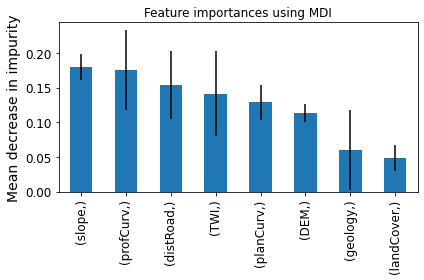

In [ ]:
#Pandas dataframe
forest_importances_1 = pd.Series(importances, index=feature_names)
#Make bars to be in ascendant order
sorted1 = forest_importances_1.sort_values('index', ascending=False)
#Make bar plot
fig, ax = plt.subplots()
sorted1.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()
#plt.savefig("bar_plot_MDI.png") #saving image

Variables with a mean >= 0.15 are listed here:

In [ ]:
var_import_1 = forest_importances_1[forest_importances_1 >= 0.15]
var_import_1

slope       0.179633
profCurv    0.175162
distRoad    0.153823
dtype: float64

Second method for Feature importance - Feature Permutation. *Source: <a href="https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html">scikit-learn</a>; <a href="https://datavizpyr.com/bar-plots-with-matplotlib-in-python/#:~:text=To%20create%20barplot%20with%20bars,with%20Pandas%20sort_values()%20function.&text=We%20get%20dataframe%20ordered%20in%20descending%20order.">datavizpyr.com</a>.*

In [ ]:
from sklearn.inspection import permutation_importance
###
result = permutation_importance(
    rf2, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
) #Calculation for RF
#Pandas dataframe
forest_importances_2 = pd.Series(result.importances_mean, index=feature_names)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: In a future version of pandas all arguments of Series.sort_values will be keyword-only
  


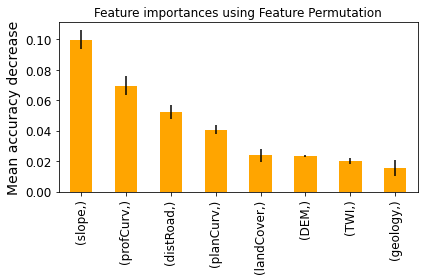

In [ ]:
#Make bars to be in ascendant order
sorted2 = forest_importances_2.sort_values('index', ascending=False)
#Make bar plot
fig, ax = plt.subplots()
sorted2.plot.bar(yerr=result.importances_std, ax=ax, color='orange')
ax.set_title("Feature importances using Feature Permutation")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()
#plt.savefig("bar_plot_FP.png") # saving image

Variables with a mean >= 0.05 are listed here:

In [ ]:
var_import_2 = forest_importances_2[forest_importances_2 >= 0.05]
var_import_2

slope       0.099708
profCurv    0.069644
distRoad    0.052131
dtype: float64

## Part V: Feature importance for Gradient Boosting Classifier.

Finally, it is insightful to complement the analysis with a feature importance applied to another algorithm. In the next cell, Gradient Boosting Classifier is computed: *Source: <a href="https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html#sklearn.ensemble.GradientBoostingClassifier.feature_importances_">scikit-learn</a>.*

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
###
gbc = GradientBoostingClassifier(n_estimators=300, learning_rate=1.0, max_depth=1, random_state=rnd_seed).fit(X_train, y_train)
gbc.score(X_test, y_test) #Evaluation of GB

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.7997664915353182

The feature importance is determined with Permutation Importance method, the most appropriate for GradientBoostClassifier.  *Source: <a href="https://scikit-learn.org/stable/modules/generated/sklearn.inspection.permutation_importance.html#sklearn.inspection.permutation_importance">scikit-learn</a>.*

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: In a future version of pandas all arguments of Series.sort_values will be keyword-only
  """


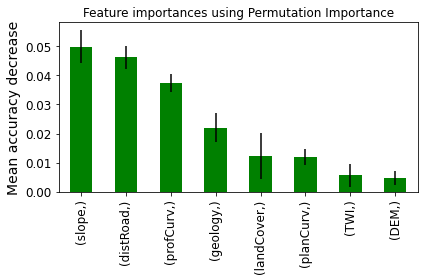

In [ ]:
boost = sklearn.inspection.permutation_importance(gbc, X_test, y_test, scoring=None, n_repeats=5, n_jobs=None, random_state=None, sample_weight=None, max_samples=1.0)
#Pandas dataframe
boost_importances = pd.Series(boost.importances_mean, index=feature_names)
#Make bars to be in ascendant order
sorted3 = boost_importances.sort_values('index', ascending=False)
#Make bar plot
fig, ax = plt.subplots()
sorted3.plot.bar(yerr=boost.importances_std, ax=ax, color='g')
ax.set_title("Feature importances using Permutation Importance")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()
#plt.savefig("bar_plot_GBC.png") # saving image

Variables with a mean >= 0.03 are listed here:

In [ ]:
var_import_3 = boost_importances[boost_importances >= 0.03]
var_import_3

slope       0.049971
profCurv    0.037478
distRoad    0.046235
dtype: float64

That's all :)